# Carbon Footprint Optimization in Supply Chain Logistics

## Problem Statement
Traditional logistics systems focus mainly on cost and time efficiency, but they often ignore environmental impact. In this project, we build a deep learning model that predicts carbon emissions based on route data, fuel usage, weather conditions, traffic, and cargo weight. The goal is to help optimize delivery routes for lower emissions.

## Project Pipeline
1. Data Generation - Create synthetic logistics dataset
2. EDA - Explore and understand the data
3. Feature Engineering - Prepare features for modeling
4. Model Building - Deep Learning model for emission prediction
5. Route Optimization - Find optimal routes with minimal emissions
6. Evaluation & Visualization - Analyze results

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import keras
from keras import layers, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)
print("Libraries imported successfully")

TensorFlow version: 2.20.0
Libraries imported successfully


## Step 2: Generate Synthetic Dataset

Since we don't have access to real logistics data, we'll generate our own synthetic dataset with the following features:
- Route features: distance, elevation, road type
- Vehicle features: fuel type, vehicle age, engine capacity
- Environmental features: weather, temperature, traffic
- Cargo features: weight, type
- Target variable: Carbon emissions (kg CO2)

In [2]:
# Generate synthetic dataset
np.random.seed(42)
n_samples = 10000

# Route Features
distance_km = np.random.uniform(10, 500, n_samples)
elevation_change = np.random.uniform(-200, 500, n_samples)
road_types = np.random.choice(['highway', 'urban', 'rural', 'mixed'], n_samples, p=[0.4, 0.25, 0.2, 0.15])
num_stops = np.random.randint(1, 15, n_samples)

# Vehicle Features
fuel_types = np.random.choice(['diesel', 'petrol', 'hybrid', 'electric'], n_samples, p=[0.45, 0.30, 0.15, 0.10])
vehicle_age_years = np.random.randint(0, 15, n_samples)
engine_capacity_L = np.random.choice([1.5, 2.0, 2.5, 3.0, 4.0, 5.0], n_samples)
vehicle_load_capacity_kg = np.random.choice([1000, 2000, 5000, 10000, 20000], n_samples)

# Environmental Features
weather_conditions = np.random.choice(['clear', 'rainy', 'foggy', 'snowy', 'windy'], n_samples, p=[0.5, 0.2, 0.1, 0.1, 0.1])
temperature_C = np.random.uniform(-10, 40, n_samples)
traffic_level = np.random.choice(['low', 'medium', 'high', 'severe'], n_samples, p=[0.3, 0.4, 0.2, 0.1])
time_of_day = np.random.choice(['morning', 'afternoon', 'evening', 'night'], n_samples)

# Cargo Features
cargo_weight_kg = np.random.uniform(100, vehicle_load_capacity_kg * 0.9)
cargo_types = np.random.choice(['general', 'perishable', 'hazardous', 'fragile'], n_samples, p=[0.5, 0.25, 0.15, 0.1])

# Function to calculate emissions based on various factors
def calculate_emissions(row):
    base_emission = 0.1  # base emission factor kg CO2/km
    
    # fuel type multiplier
    fuel_factors = {'diesel': 2.68, 'petrol': 2.31, 'hybrid': 1.5, 'electric': 0.3}
    fuel_factor = fuel_factors.get(row['fuel_type'], 2.5)
    
    # road type multiplier
    road_factors = {'highway': 0.8, 'urban': 1.4, 'rural': 1.0, 'mixed': 1.1}
    road_factor = road_factors.get(row['road_type'], 1.0)
    
    # traffic multiplier
    traffic_factors = {'low': 0.9, 'medium': 1.0, 'high': 1.3, 'severe': 1.6}
    traffic_factor = traffic_factors.get(row['traffic_level'], 1.0)
    
    # weather multiplier
    weather_factors = {'clear': 1.0, 'rainy': 1.1, 'foggy': 1.15, 'snowy': 1.3, 'windy': 1.1}
    weather_factor = weather_factors.get(row['weather'], 1.0)
    
    # weight impact
    weight_factor = 1 + (row['cargo_weight_kg'] / 10000) * 0.5
    
    # vehicle age impact
    age_factor = 1 + (row['vehicle_age'] / 15) * 0.2
    
    # elevation impact
    elevation_factor = 1 + max(0, row['elevation_change']) / 1000
    
    # engine capacity impact
    engine_factor = 0.8 + (row['engine_capacity'] / 5) * 0.4
    
    # stops impact
    stops_factor = 1 + (row['num_stops'] / 20) * 0.3
    
    # calculate total
    emissions = (base_emission * row['distance_km'] * fuel_factor * road_factor * 
                 traffic_factor * weather_factor * weight_factor * age_factor * 
                 elevation_factor * engine_factor * stops_factor)
    
    # add some random noise
    emissions *= np.random.uniform(0.9, 1.1)
    
    return emissions

# Create dataframe
df = pd.DataFrame({
    'distance_km': distance_km,
    'elevation_change': elevation_change,
    'road_type': road_types,
    'num_stops': num_stops,
    'fuel_type': fuel_types,
    'vehicle_age': vehicle_age_years,
    'engine_capacity': engine_capacity_L,
    'load_capacity_kg': vehicle_load_capacity_kg,
    'weather': weather_conditions,
    'temperature_C': temperature_C,
    'traffic_level': traffic_level,
    'time_of_day': time_of_day,
    'cargo_weight_kg': cargo_weight_kg,
    'cargo_type': cargo_types
})

# Calculate target variable
df['carbon_emissions_kg'] = df.apply(calculate_emissions, axis=1)

print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()
print("\nStatistical Summary:")
df.describe()

Dataset Shape: (10000, 15)

Dataset Info:
<class 'pandas.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   distance_km          10000 non-null  float64
 1   elevation_change     10000 non-null  float64
 2   road_type            10000 non-null  str    
 3   num_stops            10000 non-null  int64  
 4   fuel_type            10000 non-null  str    
 5   vehicle_age          10000 non-null  int64  
 6   engine_capacity      10000 non-null  float64
 7   load_capacity_kg     10000 non-null  int64  
 8   weather              10000 non-null  str    
 9   temperature_C        10000 non-null  float64
 10  traffic_level        10000 non-null  str    
 11  time_of_day          10000 non-null  str    
 12  cargo_weight_kg      10000 non-null  float64
 13  cargo_type           10000 non-null  str    
 14  carbon_emissions_kg  10000 non-null  float64
dtypes: flo

,distance_km,elevation_change,num_stops,vehicle_age,engine_capacity,load_capacity_kg,temperature_C,cargo_weight_kg,carbon_emissions_kg
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,252.138183,153.170914,7.539800,6.935600,2.994500,7605.500000,14.959776,3480.774760,114.575204
std,140.938762,202.506185,4.000277,4.299919,1.191076,6961.861569,14.406322,4103.366916,98.481118
min,10.005701,-199.889579,1.000000,0.000000,1.500000,1000.000000,-9.991243,100.329869,0.306872
25%,130.701146,-22.237939,4.000000,3.000000,2.000000,2000.000000,2.606597,666.583988,37.521182
50%,251.339023,154.127744,8.000000,7.000000,3.000000,5000.000000,14.767393,1634.294271,91.860974
75%,372.603111,329.535455,11.000000,11.000000,4.000000,10000.000000,27.310474,4523.072549,164.181629
max,499.861660,499.947379,14.000000,14.000000,5.000000,20000.000000,39.993303,17994.912561,854.253730


## Step 3: Exploratory Data Analysis

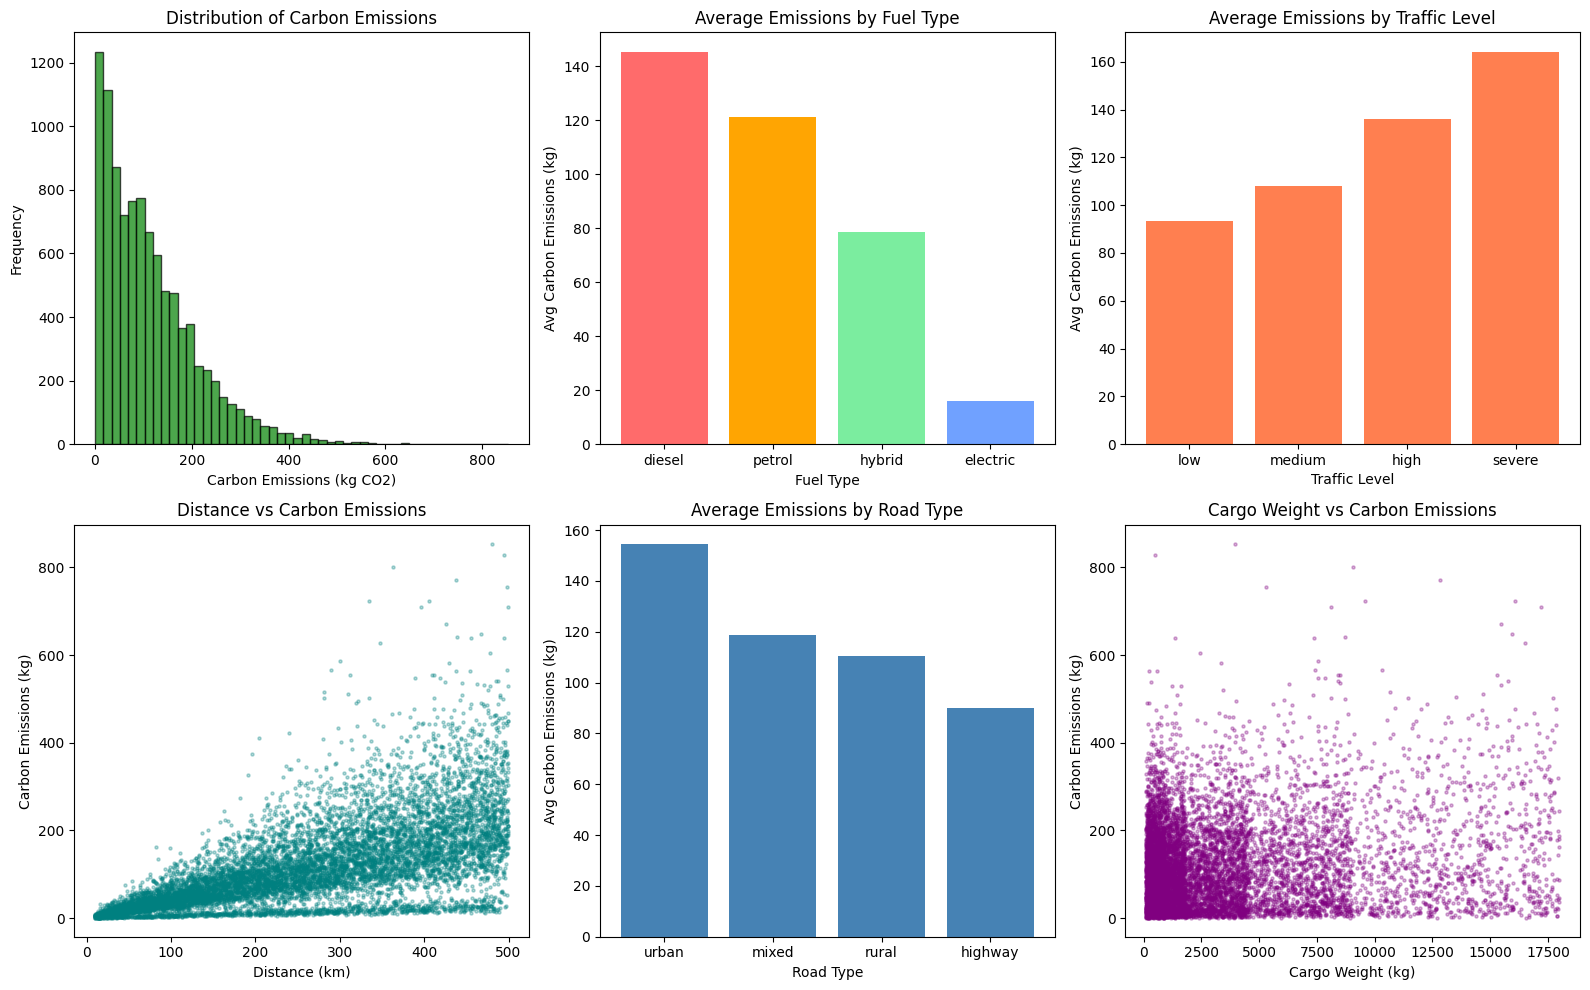

In [3]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Distribution of Carbon Emissions
axes[0, 0].hist(df['carbon_emissions_kg'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Carbon Emissions (kg CO2)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Carbon Emissions')

# Emissions by Fuel Type
fuel_emissions = df.groupby('fuel_type')['carbon_emissions_kg'].mean().sort_values(ascending=False)
axes[0, 1].bar(fuel_emissions.index, fuel_emissions.values, color=['#ff6b6b', '#ffa502', '#7bed9f', '#70a1ff'])
axes[0, 1].set_xlabel('Fuel Type')
axes[0, 1].set_ylabel('Avg Carbon Emissions (kg)')
axes[0, 1].set_title('Average Emissions by Fuel Type')

# Emissions by Traffic Level
traffic_emissions = df.groupby('traffic_level')['carbon_emissions_kg'].mean()
traffic_order = ['low', 'medium', 'high', 'severe']
axes[0, 2].bar(traffic_order, [traffic_emissions[t] for t in traffic_order], color='coral')
axes[0, 2].set_xlabel('Traffic Level')
axes[0, 2].set_ylabel('Avg Carbon Emissions (kg)')
axes[0, 2].set_title('Average Emissions by Traffic Level')

# Distance vs Emissions scatter
axes[1, 0].scatter(df['distance_km'], df['carbon_emissions_kg'], alpha=0.3, c='teal', s=5)
axes[1, 0].set_xlabel('Distance (km)')
axes[1, 0].set_ylabel('Carbon Emissions (kg)')
axes[1, 0].set_title('Distance vs Carbon Emissions')

# Emissions by Road Type
road_emissions = df.groupby('road_type')['carbon_emissions_kg'].mean().sort_values(ascending=False)
axes[1, 1].bar(road_emissions.index, road_emissions.values, color='steelblue')
axes[1, 1].set_xlabel('Road Type')
axes[1, 1].set_ylabel('Avg Carbon Emissions (kg)')
axes[1, 1].set_title('Average Emissions by Road Type')

# Cargo Weight vs Emissions
axes[1, 2].scatter(df['cargo_weight_kg'], df['carbon_emissions_kg'], alpha=0.3, c='purple', s=5)
axes[1, 2].set_xlabel('Cargo Weight (kg)')
axes[1, 2].set_ylabel('Carbon Emissions (kg)')
axes[1, 2].set_title('Cargo Weight vs Carbon Emissions')

plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/eda_analysis.png', dpi=150)
plt.show()

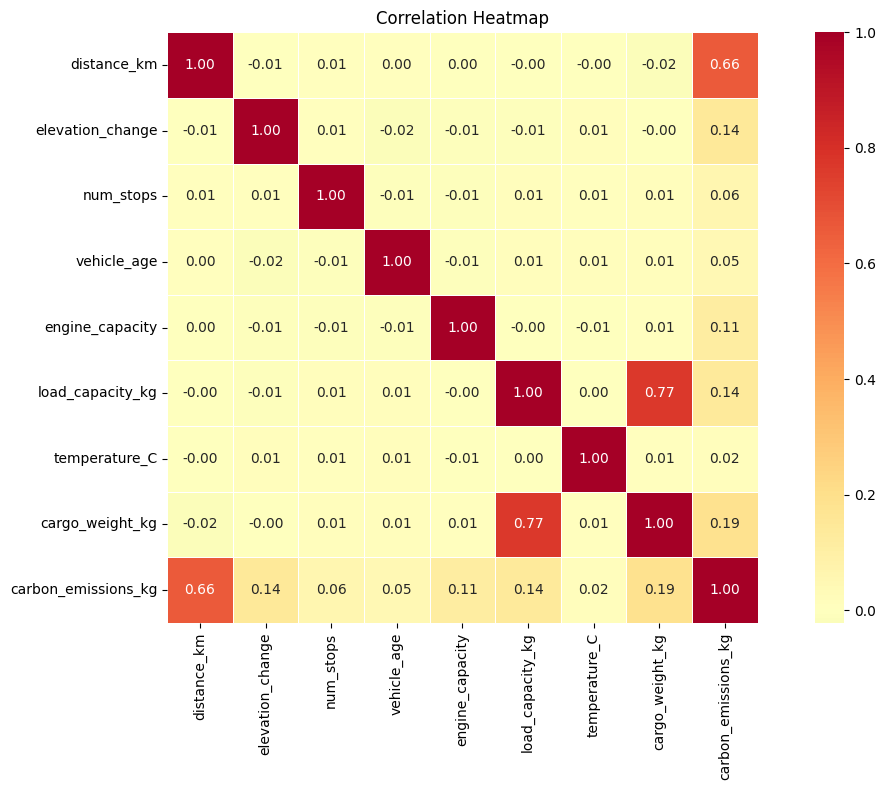


Correlations with carbon emissions:
Distance: 0.660
Cargo weight: 0.188
Engine capacity: 0.110


In [4]:
# Correlation heatmap
numerical_cols = ['distance_km', 'elevation_change', 'num_stops', 'vehicle_age', 
                  'engine_capacity', 'load_capacity_kg', 'temperature_C', 
                  'cargo_weight_kg', 'carbon_emissions_kg']

plt.figure(figsize=(12, 8))
correlation_matrix = df[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn_r', center=0, 
            fmt='.2f', square=True, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/correlation_heatmap.png', dpi=150)
plt.show()

# Key correlations with target
print("\nCorrelations with carbon emissions:")
print(f"Distance: {correlation_matrix['carbon_emissions_kg']['distance_km']:.3f}")
print(f"Cargo weight: {correlation_matrix['carbon_emissions_kg']['cargo_weight_kg']:.3f}")
print(f"Engine capacity: {correlation_matrix['carbon_emissions_kg']['engine_capacity']:.3f}")

## Step 4: Feature Engineering and Preprocessing

In [5]:
# Feature engineering
df_processed = df.copy()

# Create some additional features
df_processed['weight_to_capacity_ratio'] = df_processed['cargo_weight_kg'] / df_processed['load_capacity_kg']
df_processed['distance_per_stop'] = df_processed['distance_km'] / (df_processed['num_stops'] + 1)
df_processed['is_uphill'] = (df_processed['elevation_change'] > 0).astype(int)
df_processed['is_peak_hours'] = df_processed['time_of_day'].isin(['morning', 'evening']).astype(int)
df_processed['is_bad_weather'] = df_processed['weather'].isin(['rainy', 'foggy', 'snowy']).astype(int)

# Encode categorical variables using LabelEncoder
label_encoders = {}
categorical_cols = ['road_type', 'fuel_type', 'weather', 'traffic_level', 'time_of_day', 'cargo_type']

for col in categorical_cols:
    le = LabelEncoder()
    df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col])
    label_encoders[col] = le

# Define feature columns
feature_cols = [
    'distance_km', 'elevation_change', 'num_stops', 'vehicle_age', 'engine_capacity',
    'load_capacity_kg', 'temperature_C', 'cargo_weight_kg', 'weight_to_capacity_ratio',
    'distance_per_stop', 'is_uphill', 'is_peak_hours', 'is_bad_weather',
    'road_type_encoded', 'fuel_type_encoded', 'weather_encoded', 
    'traffic_level_encoded', 'time_of_day_encoded', 'cargo_type_encoded'
]

X = df_processed[feature_cols].values
y = df_processed['carbon_emissions_kg'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature Engineering done!")
print(f"Number of features: {len(feature_cols)}")
print(f"Training samples: {X_train_scaled.shape[0]}")
print(f"Testing samples: {X_test_scaled.shape[0]}")

Feature Engineering done!
Number of features: 19
Training samples: 8000
Testing samples: 2000


## Step 5: Build Deep Learning Model

Building a neural network with dense layers, batch normalization and dropout for regularization.

In [6]:
# Build the model
def build_emission_model(input_dim):
    inputs = layers.Input(shape=(input_dim,), name='input_features')
    
    # First layer
    x = layers.Dense(256, kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Second layer
    x = layers.Dense(128, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.3)(x)
    
    # Third layer
    x = layers.Dense(64, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.2)(x)
    
    # Fourth layer
    x = layers.Dense(32, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    # Output
    outputs = layers.Dense(1, activation='linear', name='emission_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Carbon_Emission_Model')
    return model

# Create model
model = build_emission_model(X_train_scaled.shape[1])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "Carbon_Emission_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_features (InputLayer)     │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ emission_output (Dense)         │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,305 (196.50 KB)

 Trainable params: 49,345 (192.75 KB)

 Non-trainable params: 960 (3.75 KB)

In [7]:
# Training with callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

print("Training model...")
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("Training complete!")

Training model...
Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21976.5195 - mae: 112.2748 - val_loss: 20179.6758 - val_mae: 110.3259 - learning_rate: 0.0010
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20878.5801 - mae: 109.9003 - val_loss: 19024.3770 - val_mae: 107.3256 - learning_rate: 0.0010
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19658.7266 - mae: 106.7111 - val_loss: 18040.5879 - val_mae: 104.5790 - learning_rate: 0.0010
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18229.4395 - mae: 102.8007 - val_loss: 16842.4023 - val_mae: 101.2968 - learning_rate: 0.0010
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16616.3398 - mae: 98.5311 - val_loss: 14936.6650 - val_mae: 95.8637 - learning_rate: 0.0010
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14749.8662 - mae: 93.3352 - val_loss: 12780.8223 - val_mae: 89.3078 - learning_rate: 0.0010
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

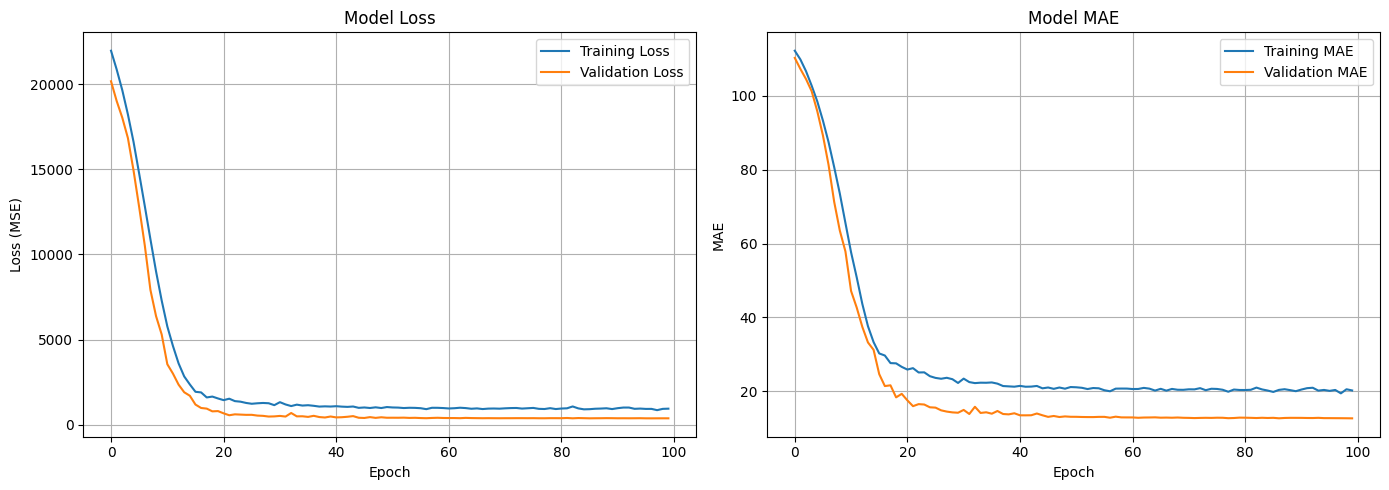

In [8]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Training Loss')
axes[0].plot(history.history['val_loss'], label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True)

# MAE
axes[1].plot(history.history['mae'], label='Training MAE')
axes[1].plot(history.history['val_mae'], label='Validation MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Model MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/training_history.png', dpi=150)
plt.show()

## Step 6: Model Evaluation

Model Evaluation Results
MSE: 355.1779
RMSE: 18.8462 kg CO2
MAE: 12.2416 kg CO2
R2 Score: 0.9620
MAPE: 24.14%


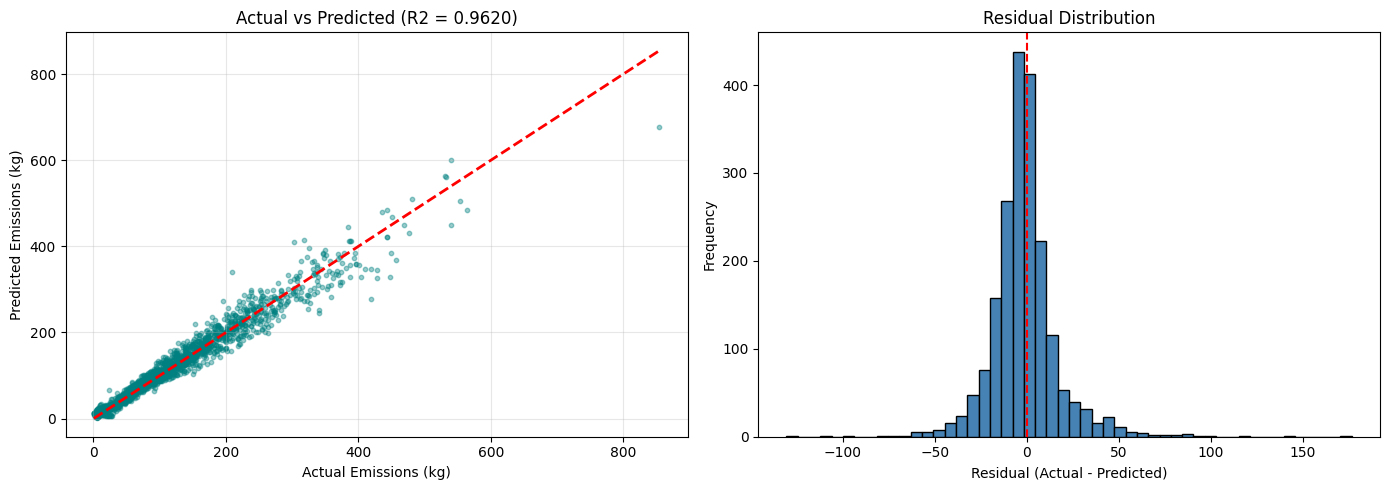

In [9]:
# Evaluate on test set
y_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("Model Evaluation Results")
print("="*40)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f} kg CO2")
print(f"MAE: {mae:.4f} kg CO2")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual vs Predicted
axes[0].scatter(y_test, y_pred, alpha=0.4, s=10, c='teal')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Emissions (kg)')
axes[0].set_ylabel('Predicted Emissions (kg)')
axes[0].set_title(f'Actual vs Predicted (R2 = {r2:.4f})')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = y_test - y_pred
axes[1].hist(residuals, bins=50, color='steelblue', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/model_evaluation.png', dpi=150)
plt.show()

## Step 7: Route Optimization

Creating a simple route optimizer that compares different routes and suggests the one with lowest emissions.

In [10]:
# Route Optimizer class
class GreenRouteOptimizer:
    def __init__(self, model, scaler, label_encoders, feature_cols):
        self.model = model
        self.scaler = scaler
        self.label_encoders = label_encoders
        self.feature_cols = feature_cols
    
    def prepare_route_features(self, route_data):
        # Create derived features
        route_data['weight_to_capacity_ratio'] = route_data['cargo_weight_kg'] / route_data['load_capacity_kg']
        route_data['distance_per_stop'] = route_data['distance_km'] / (route_data['num_stops'] + 1)
        route_data['is_uphill'] = int(route_data['elevation_change'] > 0)
        route_data['is_peak_hours'] = int(route_data['time_of_day'] in ['morning', 'evening'])
        route_data['is_bad_weather'] = int(route_data['weather'] in ['rainy', 'foggy', 'snowy'])
        
        # Encode categorical vars
        categorical_cols = ['road_type', 'fuel_type', 'weather', 'traffic_level', 'time_of_day', 'cargo_type']
        for col in categorical_cols:
            if col in route_data:
                route_data[f'{col}_encoded'] = self.label_encoders[col].transform([route_data[col]])[0]
        
        # Get features in correct order
        features = [route_data[col.replace('_encoded', '') + '_encoded'] if '_encoded' in col 
                   else route_data[col] for col in self.feature_cols]
        
        return np.array(features).reshape(1, -1)
    
    def predict_emissions(self, route_data):
        features = self.prepare_route_features(route_data.copy())
        features_scaled = self.scaler.transform(features)
        emission = self.model.predict(features_scaled, verbose=0)[0][0]
        return emission
    
    def optimize_routes(self, routes_list):
        results = []
        for i, route in enumerate(routes_list):
            emission = self.predict_emissions(route)
            results.append({
                'route_id': i + 1,
                'route_name': route.get('route_name', f'Route {i+1}'),
                'distance_km': route['distance_km'],
                'fuel_type': route['fuel_type'],
                'road_type': route['road_type'],
                'traffic_level': route['traffic_level'],
                'predicted_emissions_kg': emission
            })
        
        results_df = pd.DataFrame(results)
        results_df = results_df.sort_values('predicted_emissions_kg')
        results_df['emission_rank'] = range(1, len(results_df) + 1)
        results_df['savings_vs_worst'] = results_df['predicted_emissions_kg'].max() - results_df['predicted_emissions_kg']
        results_df['savings_percent'] = (results_df['savings_vs_worst'] / results_df['predicted_emissions_kg'].max()) * 100
        
        return results_df

# Initialize optimizer
optimizer = GreenRouteOptimizer(model, scaler, label_encoders, feature_cols)
print("Route Optimizer initialized!")

Route Optimizer initialized!


In [11]:
# Test with sample routes
sample_routes = [
    {
        'route_name': 'Highway Route (Diesel)',
        'distance_km': 150, 'elevation_change': 50, 'num_stops': 3,
        'fuel_type': 'diesel', 'vehicle_age': 5, 'engine_capacity': 4.0,
        'load_capacity_kg': 10000, 'weather': 'clear', 'temperature_C': 20,
        'traffic_level': 'low', 'time_of_day': 'morning', 
        'cargo_weight_kg': 5000, 'cargo_type': 'general', 'road_type': 'highway'
    },
    {
        'route_name': 'Urban Route (Diesel)',
        'distance_km': 120, 'elevation_change': 20, 'num_stops': 8,
        'fuel_type': 'diesel', 'vehicle_age': 5, 'engine_capacity': 4.0,
        'load_capacity_kg': 10000, 'weather': 'clear', 'temperature_C': 20,
        'traffic_level': 'high', 'time_of_day': 'morning', 
        'cargo_weight_kg': 5000, 'cargo_type': 'general', 'road_type': 'urban'
    },
    {
        'route_name': 'Highway Route (Hybrid)',
        'distance_km': 150, 'elevation_change': 50, 'num_stops': 3,
        'fuel_type': 'hybrid', 'vehicle_age': 2, 'engine_capacity': 3.0,
        'load_capacity_kg': 10000, 'weather': 'clear', 'temperature_C': 20,
        'traffic_level': 'low', 'time_of_day': 'morning', 
        'cargo_weight_kg': 5000, 'cargo_type': 'general', 'road_type': 'highway'
    },
    {
        'route_name': 'Highway Route (Electric)',
        'distance_km': 160, 'elevation_change': 60, 'num_stops': 3,
        'fuel_type': 'electric', 'vehicle_age': 1, 'engine_capacity': 2.0,
        'load_capacity_kg': 8000, 'weather': 'clear', 'temperature_C': 20,
        'traffic_level': 'low', 'time_of_day': 'morning', 
        'cargo_weight_kg': 5000, 'cargo_type': 'general', 'road_type': 'highway'
    },
    {
        'route_name': 'Rural Route (Diesel)',
        'distance_km': 180, 'elevation_change': 100, 'num_stops': 2,
        'fuel_type': 'diesel', 'vehicle_age': 5, 'engine_capacity': 4.0,
        'load_capacity_kg': 10000, 'weather': 'clear', 'temperature_C': 20,
        'traffic_level': 'low', 'time_of_day': 'afternoon', 
        'cargo_weight_kg': 5000, 'cargo_type': 'general', 'road_type': 'rural'
    }
]

# Get optimization results
optimization_results = optimizer.optimize_routes(sample_routes)

print("Route Optimization Results (Ranked by Emissions)")
print("="*80)
print(optimization_results[['emission_rank', 'route_name', 'distance_km', 'fuel_type', 
                            'traffic_level', 'predicted_emissions_kg', 'savings_percent']].to_string(index=False))
print("="*80)
print(f"\nRecommended Route: {optimization_results.iloc[0]['route_name']}")
print(f"Predicted Emissions: {optimization_results.iloc[0]['predicted_emissions_kg']:.2f} kg CO2")

Route Optimization Results (Ranked by Emissions)
 emission_rank               route_name  distance_km fuel_type traffic_level  predicted_emissions_kg  savings_percent
             1 Highway Route (Electric)          160  electric           low                5.022385        94.779434
             2   Highway Route (Hybrid)          150    hybrid           low                8.756424        90.898056
             3   Highway Route (Diesel)          150    diesel           low               55.100918        42.724831
             4     Rural Route (Diesel)          180    diesel           low               88.854393         7.639462
             5     Urban Route (Diesel)          120    diesel          high               96.203850         0.000000

Recommended Route: Highway Route (Electric)
Predicted Emissions: 5.02 kg CO2


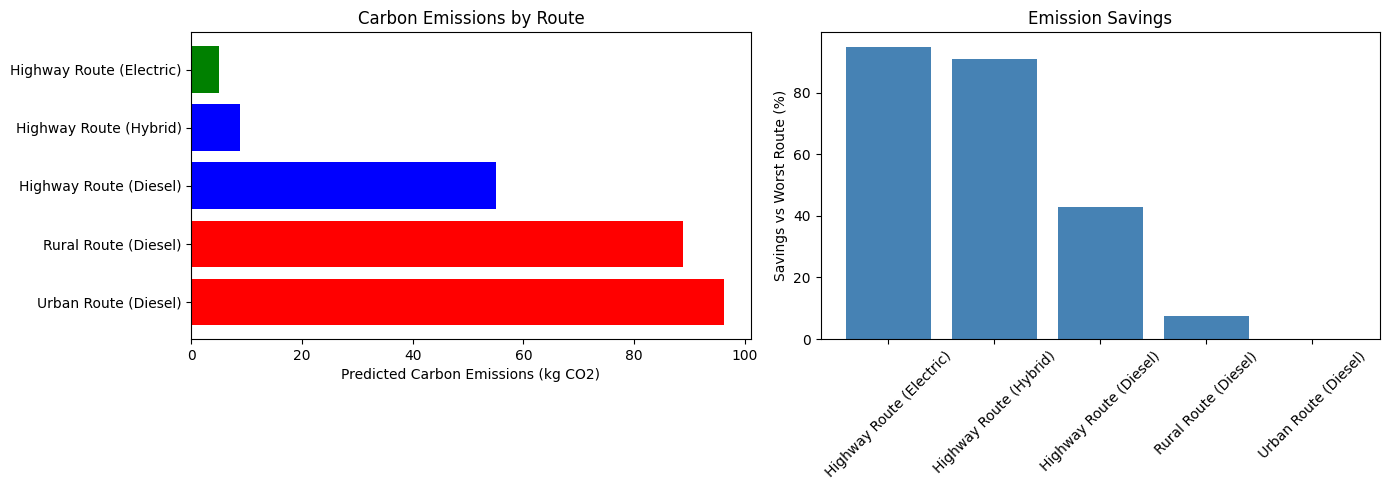

In [12]:
# Visualize route comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Emissions comparison
colors = ['green' if i == 0 else 'blue' if i < 3 else 'red' 
          for i in range(len(optimization_results))]
bars = axes[0].barh(optimization_results['route_name'], 
                    optimization_results['predicted_emissions_kg'],
                    color=colors)
axes[0].set_xlabel('Predicted Carbon Emissions (kg CO2)')
axes[0].set_title('Carbon Emissions by Route')
axes[0].invert_yaxis()

# Savings comparison
axes[1].bar(optimization_results['route_name'], 
            optimization_results['savings_percent'],
            color='steelblue')
axes[1].set_ylabel('Savings vs Worst Route (%)')
axes[1].set_title('Emission Savings')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/route_optimization.png', dpi=150)
plt.show()

## Step 8: Feature Importance

Let's see which features have the most impact on carbon emissions.

Calculating feature importance...


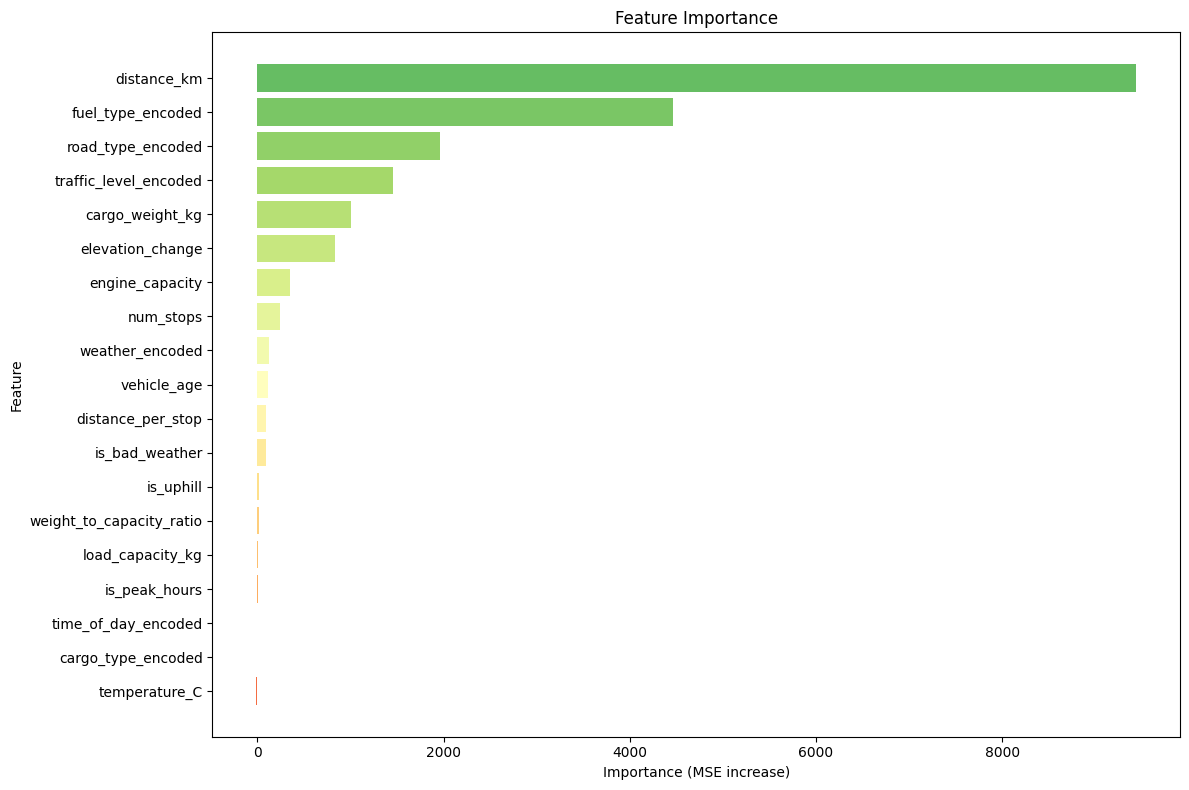


Top 5 Important Features:
  distance_km: 9436.5693
  fuel_type_encoded: 4463.1479
  road_type_encoded: 1959.5081
  traffic_level_encoded: 1455.1290
  cargo_weight_kg: 1004.7108


In [13]:
# Calculate feature importance using permutation method
def calculate_feature_importance(model, X_test, y_test, feature_names, n_repeats=3):
    # Get baseline
    baseline_pred = model.predict(X_test, verbose=0).flatten()
    baseline_mse = np.mean((y_test - baseline_pred) ** 2)
    
    importances = []
    for i in range(X_test.shape[1]):
        feature_importance = []
        for _ in range(n_repeats):
            X_permuted = X_test.copy()
            np.random.shuffle(X_permuted[:, i])
            
            permuted_pred = model.predict(X_permuted, verbose=0).flatten()
            permuted_mse = np.mean((y_test - permuted_pred) ** 2)
            
            feature_importance.append(permuted_mse - baseline_mse)
        
        importances.append({
            'feature': feature_names[i],
            'importance': np.mean(feature_importance),
            'std': np.std(feature_importance)
        })
    
    return pd.DataFrame(importances).sort_values('importance', ascending=False)

print("Calculating feature importance...")
importance_df = calculate_feature_importance(model, X_test_scaled, y_test, feature_cols)

# Plot
plt.figure(figsize=(12, 8))
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(importance_df)))
plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.xlabel('Importance (MSE increase)')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('/Users/kautukmadankar/Desktop/Carbon Emission/feature_importance.png', dpi=150)
plt.show()

print("\nTop 5 Important Features:")
for idx, row in importance_df.head(5).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Step 9: Save Model and Artifacts

In [14]:
import joblib
import os

save_path = '/Users/kautukmadankar/Desktop/Carbon Emission'

# Save model
model.save(os.path.join(save_path, 'carbon_emission_model.keras'))

# Save other artifacts
joblib.dump(scaler, os.path.join(save_path, 'feature_scaler.pkl'))
joblib.dump(label_encoders, os.path.join(save_path, 'label_encoders.pkl'))
joblib.dump(feature_cols, os.path.join(save_path, 'feature_columns.pkl'))

# Save dataset
df.to_csv(os.path.join(save_path, 'logistics_emissions_dataset.csv'), index=False)

print("All files saved!")
print("Saved files:")
print("  - carbon_emission_model.keras")
print("  - feature_scaler.pkl")
print("  - label_encoders.pkl") 
print("  - feature_columns.pkl")
print("  - logistics_emissions_dataset.csv")

All files saved!
Saved files:
  - carbon_emission_model.keras
  - feature_scaler.pkl
  - label_encoders.pkl
  - feature_columns.pkl
  - logistics_emissions_dataset.csv


## Step 10: Demo - Predict for Custom Route

In [15]:
# Function to predict emissions for custom route
def predict_custom_route(distance_km=100, elevation_change=0, num_stops=3,
                         fuel_type='diesel', vehicle_age=5, engine_capacity=3.0,
                         load_capacity_kg=5000, weather='clear', temperature_C=20,
                         traffic_level='medium', time_of_day='morning',
                         cargo_weight_kg=2000, cargo_type='general', road_type='highway'):
    
    route_data = {
        'distance_km': distance_km,
        'elevation_change': elevation_change,
        'num_stops': num_stops,
        'fuel_type': fuel_type,
        'vehicle_age': vehicle_age,
        'engine_capacity': engine_capacity,
        'load_capacity_kg': load_capacity_kg,
        'weather': weather,
        'temperature_C': temperature_C,
        'traffic_level': traffic_level,
        'time_of_day': time_of_day,
        'cargo_weight_kg': cargo_weight_kg,
        'cargo_type': cargo_type,
        'road_type': road_type
    }
    
    emission = optimizer.predict_emissions(route_data)
    
    print("Carbon Emission Prediction")
    print("="*50)
    print(f"Distance: {distance_km} km")
    print(f"Road Type: {road_type}")
    print(f"Fuel Type: {fuel_type}")
    print(f"Traffic: {traffic_level}")
    print(f"Cargo Weight: {cargo_weight_kg} kg")
    print(f"\nPredicted Emissions: {emission:.2f} kg CO2")
    print("="*50)
    
    return emission

# Example
emission = predict_custom_route(
    distance_km=200,
    road_type='highway',
    fuel_type='diesel',
    traffic_level='medium',
    cargo_weight_kg=3000
)

Carbon Emission Prediction
Distance: 200 km
Road Type: highway
Fuel Type: diesel
Traffic: medium
Cargo Weight: 3000 kg

Predicted Emissions: 71.79 kg CO2


## Conclusion

In this project, we built a deep learning model to predict carbon emissions from logistics data. The main findings are:

**What we did:**
- Generated a synthetic dataset with 10,000 logistics records
- Performed EDA to understand the data
- Built a neural network model for emission prediction
- Created a route optimizer to compare different routes

**Key findings:**
- Distance is the strongest predictor of emissions
- Electric/hybrid vehicles produce significantly lower emissions
- Urban routes with high traffic generate more emissions than highway routes

**Future improvements:**
- Use real-world logistics data instead of synthetic
- Add more features like driver behavior
- Create a web interface for easier use
- Consider multi-objective optimization (cost + time + emissions)